In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [3]:
NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

In [4]:
threshold = 0
column_to_predict = "kg_CO2/kWh"

independent_variables = []


for column in train:
    if abs(train[column].corr(train[column_to_predict])) > threshold:
        independent_variables.append(column)

independent_variables.remove(column_to_predict)
independent_variables.remove("Index")
independent_variables

['Hour_1',
 'Day Type_1',
 'Indoor Temperature (C)_1',
 'Average Unmet Cooling Setpoint Difference (C)_1',
 'Indoor Relative Humidity (%)_1',
 'Equipment Electric Power (kWh)_1',
 'DHW Heating (kWh)_1',
 'Cooling Load (kWh)_1',
 'Solar Generation (W/kW)_1',
 'Occupant Count (people)_1',
 'Temperature Set Point (C)_1',
 'Hour_2',
 'Day Type_2',
 'Indoor Temperature (C)_2',
 'Average Unmet Cooling Setpoint Difference (C)_2',
 'Indoor Relative Humidity (%)_2',
 'Equipment Electric Power (kWh)_2',
 'DHW Heating (kWh)_2',
 'Cooling Load (kWh)_2',
 'Solar Generation (W/kW)_2',
 'Occupant Count (people)_2',
 'Temperature Set Point (C)_2',
 'Hour_3',
 'Day Type_3',
 'Indoor Temperature (C)_3',
 'Average Unmet Cooling Setpoint Difference (C)_3',
 'Indoor Relative Humidity (%)_3',
 'Equipment Electric Power (kWh)_3',
 'DHW Heating (kWh)_3',
 'Cooling Load (kWh)_3',
 'Solar Generation (W/kW)_3',
 'Occupant Count (people)_3',
 'Temperature Set Point (C)_3',
 'Outdoor Drybulb Temperature (C)',
 'Ou

In [5]:
X_train = train[independent_variables]
# X_train = train[["Hour_1", "Day Type_1"]]
Y_train = train[column_to_predict]

In [6]:
X_train.shape

(648, 50)

In [17]:
X_train.head()

,Hour_1,Day Type_1,Indoor Temperature (C)_1,Average Unmet Cooling Setpoint Difference (C)_1,Indoor Relative Humidity (%)_1,Equipment Electric Power (kWh)_1,DHW Heating (kWh)_1,Cooling Load (kWh)_1,Solar Generation (W/kW)_1,Occupant Count (people)_1,...,6h Outdoor Relative Humidity (%),12h Outdoor Relative Humidity (%),24h Outdoor Relative Humidity (%),6h Diffuse Solar Radiation (W/m2),12h Diffuse Solar Radiation (W/m2),24h Diffuse Solar Radiation (W/m2),6h Direct Solar Radiation (W/m2),12h Direct Solar Radiation (W/m2),24h Direct Solar Radiation (W/m2),Avg solar generation
0,0.000000,0.666667,0.429050,0.194375,0.683582,0.005211,0.012197,0.105501,0.0,1.0,...,0.664642,0.284653,0.798775,0.118430,0.210593,0.0,0.135681,0.903531,0.0,0.0
1,0.043478,0.666667,0.309434,0.424188,0.836691,0.003564,0.034902,0.138533,0.0,1.0,...,0.842592,0.236548,0.944248,0.169919,0.160807,0.0,0.284343,0.730342,0.0,0.0
2,0.086957,0.666667,0.307816,0.404461,0.842864,0.002680,0.012486,0.137471,0.0,1.0,...,0.507773,0.141625,0.595202,0.563298,0.149336,0.0,0.186202,0.874457,0.0,0.0
3,0.130435,0.666667,0.307704,0.403094,0.855780,0.002132,0.000000,0.126063,0.0,1.0,...,0.380213,0.157973,0.933477,0.539037,0.189482,0.0,0.440659,0.756219,0.0,0.0
4,0.173913,0.666667,0.307702,0.403069,0.873657,0.004058,0.000000,0.109671,0.0,1.0,...,0.267002,0.177644,1.000000,0.591489,0.136309,0.0,0.538847,0.833150,0.0,0.0


In [7]:
def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        #print(f"i = {i}, seq = {seq}")
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        #print(f"i = {i}, target = {target}")
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [8]:
input_sequences, target_variables = create_sequences(X_train, Y_train, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
print(input_sequences[0])
print(target_variables[0])
print(input_sequences.shape)
print(target_variables.shape)

[[0.         0.66666667 0.42905032 ... 0.90353129 0.         0.        ]
 [0.04347826 0.66666667 0.30943362 ... 0.73034217 0.         0.        ]
 [0.08695652 0.66666667 0.30781619 ... 0.87445669 0.         0.        ]
 ...
 [0.91304348 0.83333333 0.29064017 ... 0.29065842 0.         0.        ]
 [0.95652174 0.83333333 0.04895782 ... 0.59164279 0.         0.        ]
 [1.         0.83333333 0.00208331 ... 0.53563308 0.         0.        ]]
[0.59739428 0.49429981 0.38708765 0.28880037 0.2346659  0.22880156
 0.26241434 0.31385395 0.36274065 0.32912399 0.41859464 0.59690114
 0.74685743 0.82796725 0.84589733 0.83725959 0.82125879 0.80709442
 0.78806505 0.73835998 0.71748058 0.73547528 0.69513525 0.71729728]
(577, 48, 50)
(577, 24)


In [9]:
# importing libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.optimizers import SGD

2023-12-04 15:12:18.252425: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 15:12:18.488728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 15:12:18.488775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 15:12:18.503163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 15:12:18.530682: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 15:12:18.531119: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [19]:
print(input_sequences.shape)
print(input_sequences[0])
print(input_sequences[0].flatten())

(577, 48, 50)
[[0.         0.66666667 0.42905032 ... 0.90353129 0.         0.        ]
 [0.04347826 0.66666667 0.30943362 ... 0.73034217 0.         0.        ]
 [0.08695652 0.66666667 0.30781619 ... 0.87445669 0.         0.        ]
 ...
 [0.91304348 0.83333333 0.29064017 ... 0.29065842 0.         0.        ]
 [0.95652174 0.83333333 0.04895782 ... 0.59164279 0.         0.        ]
 [1.         0.83333333 0.00208331 ... 0.53563308 0.         0.        ]]
[0.         0.66666667 0.42905032 ... 0.53563308 0.         0.        ]


In [64]:
# initializing the sequential RNN
model = keras.Sequential([
        
        # TODO I think this might be needed to group by timestamps rather than variables
        keras.layers.Permute((2,1), input_shape=(48,50)),
        
        # include a flatten layer to convert to 1D (used as a first layer instead of reshaping)
        keras.layers.Flatten(input_shape=(50,48)),
        # shape should be vertically, so 48 data points for x1, then x2...
        keras.layers.Dense(20, activation='tanh'),
        # keras.layers.Dropout(0.2),   no dropout yet
        keras.layers.Dense(20, activation='tanh'),
        keras.layers.Dense(20, activation='tanh'),
        keras.layers.Dense(24)
    ]) #amount of layers & neurons to be adjusted

# compiling RNN
model.compile(optimizer = SGD(learning_rate=0.01, 
                                  momentum=0.9, 
                                  nesterov=True), 
                  loss = "mean_squared_error")

model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_13 (Permute)        (None, 50, 48)            0         
                                                                 
 flatten_7 (Flatten)         (None, 2400)              0         
                                                                 
 dense_21 (Dense)            (None, 48)                115248    
                                                                 
 dense_22 (Dense)            (None, 48)                2352      
                                                                 
 dense_23 (Dense)            (None, 24)                1176      
                                                                 
 dense_24 (Dense)            (None, 24)                600       
                                                                 
Total params: 119376 (466.31 KB)
Trainable params: 11

In [65]:
# fitting the model
history = model.fit(input_sequences, target_variables, epochs = 200, verbose=1)

Epoch 1/200
19/19 [==============================] - 0s 1ms/step - loss: 0.1623
Epoch 2/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 3/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0447
Epoch 4/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0424
Epoch 5/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0409
Epoch 6/200
19/19 [==============================] - 0s 2ms/step - loss: 0.0392
Epoch 7/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0382
Epoch 8/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0366
Epoch 9/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0354
Epoch 10/200
19/19 [==============================] - 0s 3ms/step - loss: 0.0341
Epoch 11/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0328
Epoch 12/200
19/19 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 13/200
19/19 [=================

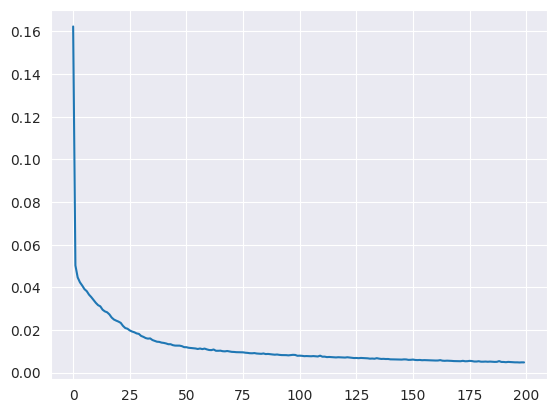

In [66]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [67]:
# Prepare data for evaluation
X_test = test[independent_variables]
# X_test = train[["Hour_1", "Day Type_1"]]
Y_test = test[column_to_predict]

# Append last 24 hours from train
last_24_X = X_train.tail(24)
last_24_Y = Y_train.tail(24)

X_test = pd.concat([last_24_X, X_test], ignore_index=True)
Y_test = pd.concat([last_24_Y, Y_test], ignore_index=True)

eval_input_sequences, eval_target_variables = create_sequences(X_test, Y_test, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
print(Y_test)
print(eval_input_sequences.shape)
print(eval_target_variables.shape)

0     0.353082
1     0.256588
2     0.215438
3     0.201465
4     0.186162
        ...   
91    0.587037
92    0.607686
93    0.571493
94    0.508506
95    0.414290
Name: kg_CO2/kWh, Length: 96, dtype: float64
(25, 48, 50)
(25, 24)


In [68]:
# Evaluate the model on the test data
predictions = []
#print(len(eval_target_variables))

for i in range(len(eval_target_variables)):
    current_batch = eval_input_sequences[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, 50))
    curr_pred = model.predict(current_batch)
    predictions.append(curr_pred)

#print(predictions)


1/1 [==============================] - 0s 13ms/step


In [69]:
print(target_variables)

[[0.59739428 0.49429981 0.38708765 ... 0.73547528 0.69513525 0.71729728]
 [0.49429981 0.38708765 0.28880037 ... 0.69513525 0.71729728 0.6633147 ]
 [0.38708765 0.28880037 0.2346659  ... 0.71729728 0.6633147  0.55539687]
 ...
 [0.58203406 0.47630759 0.35308157 ... 0.72064381 0.72593017 0.70952622]
 [0.47630759 0.35308157 0.25658758 ... 0.72593017 0.70952622 0.60912381]
 [0.35308157 0.25658758 0.21543843 ... 0.70952622 0.60912381 0.49323911]]


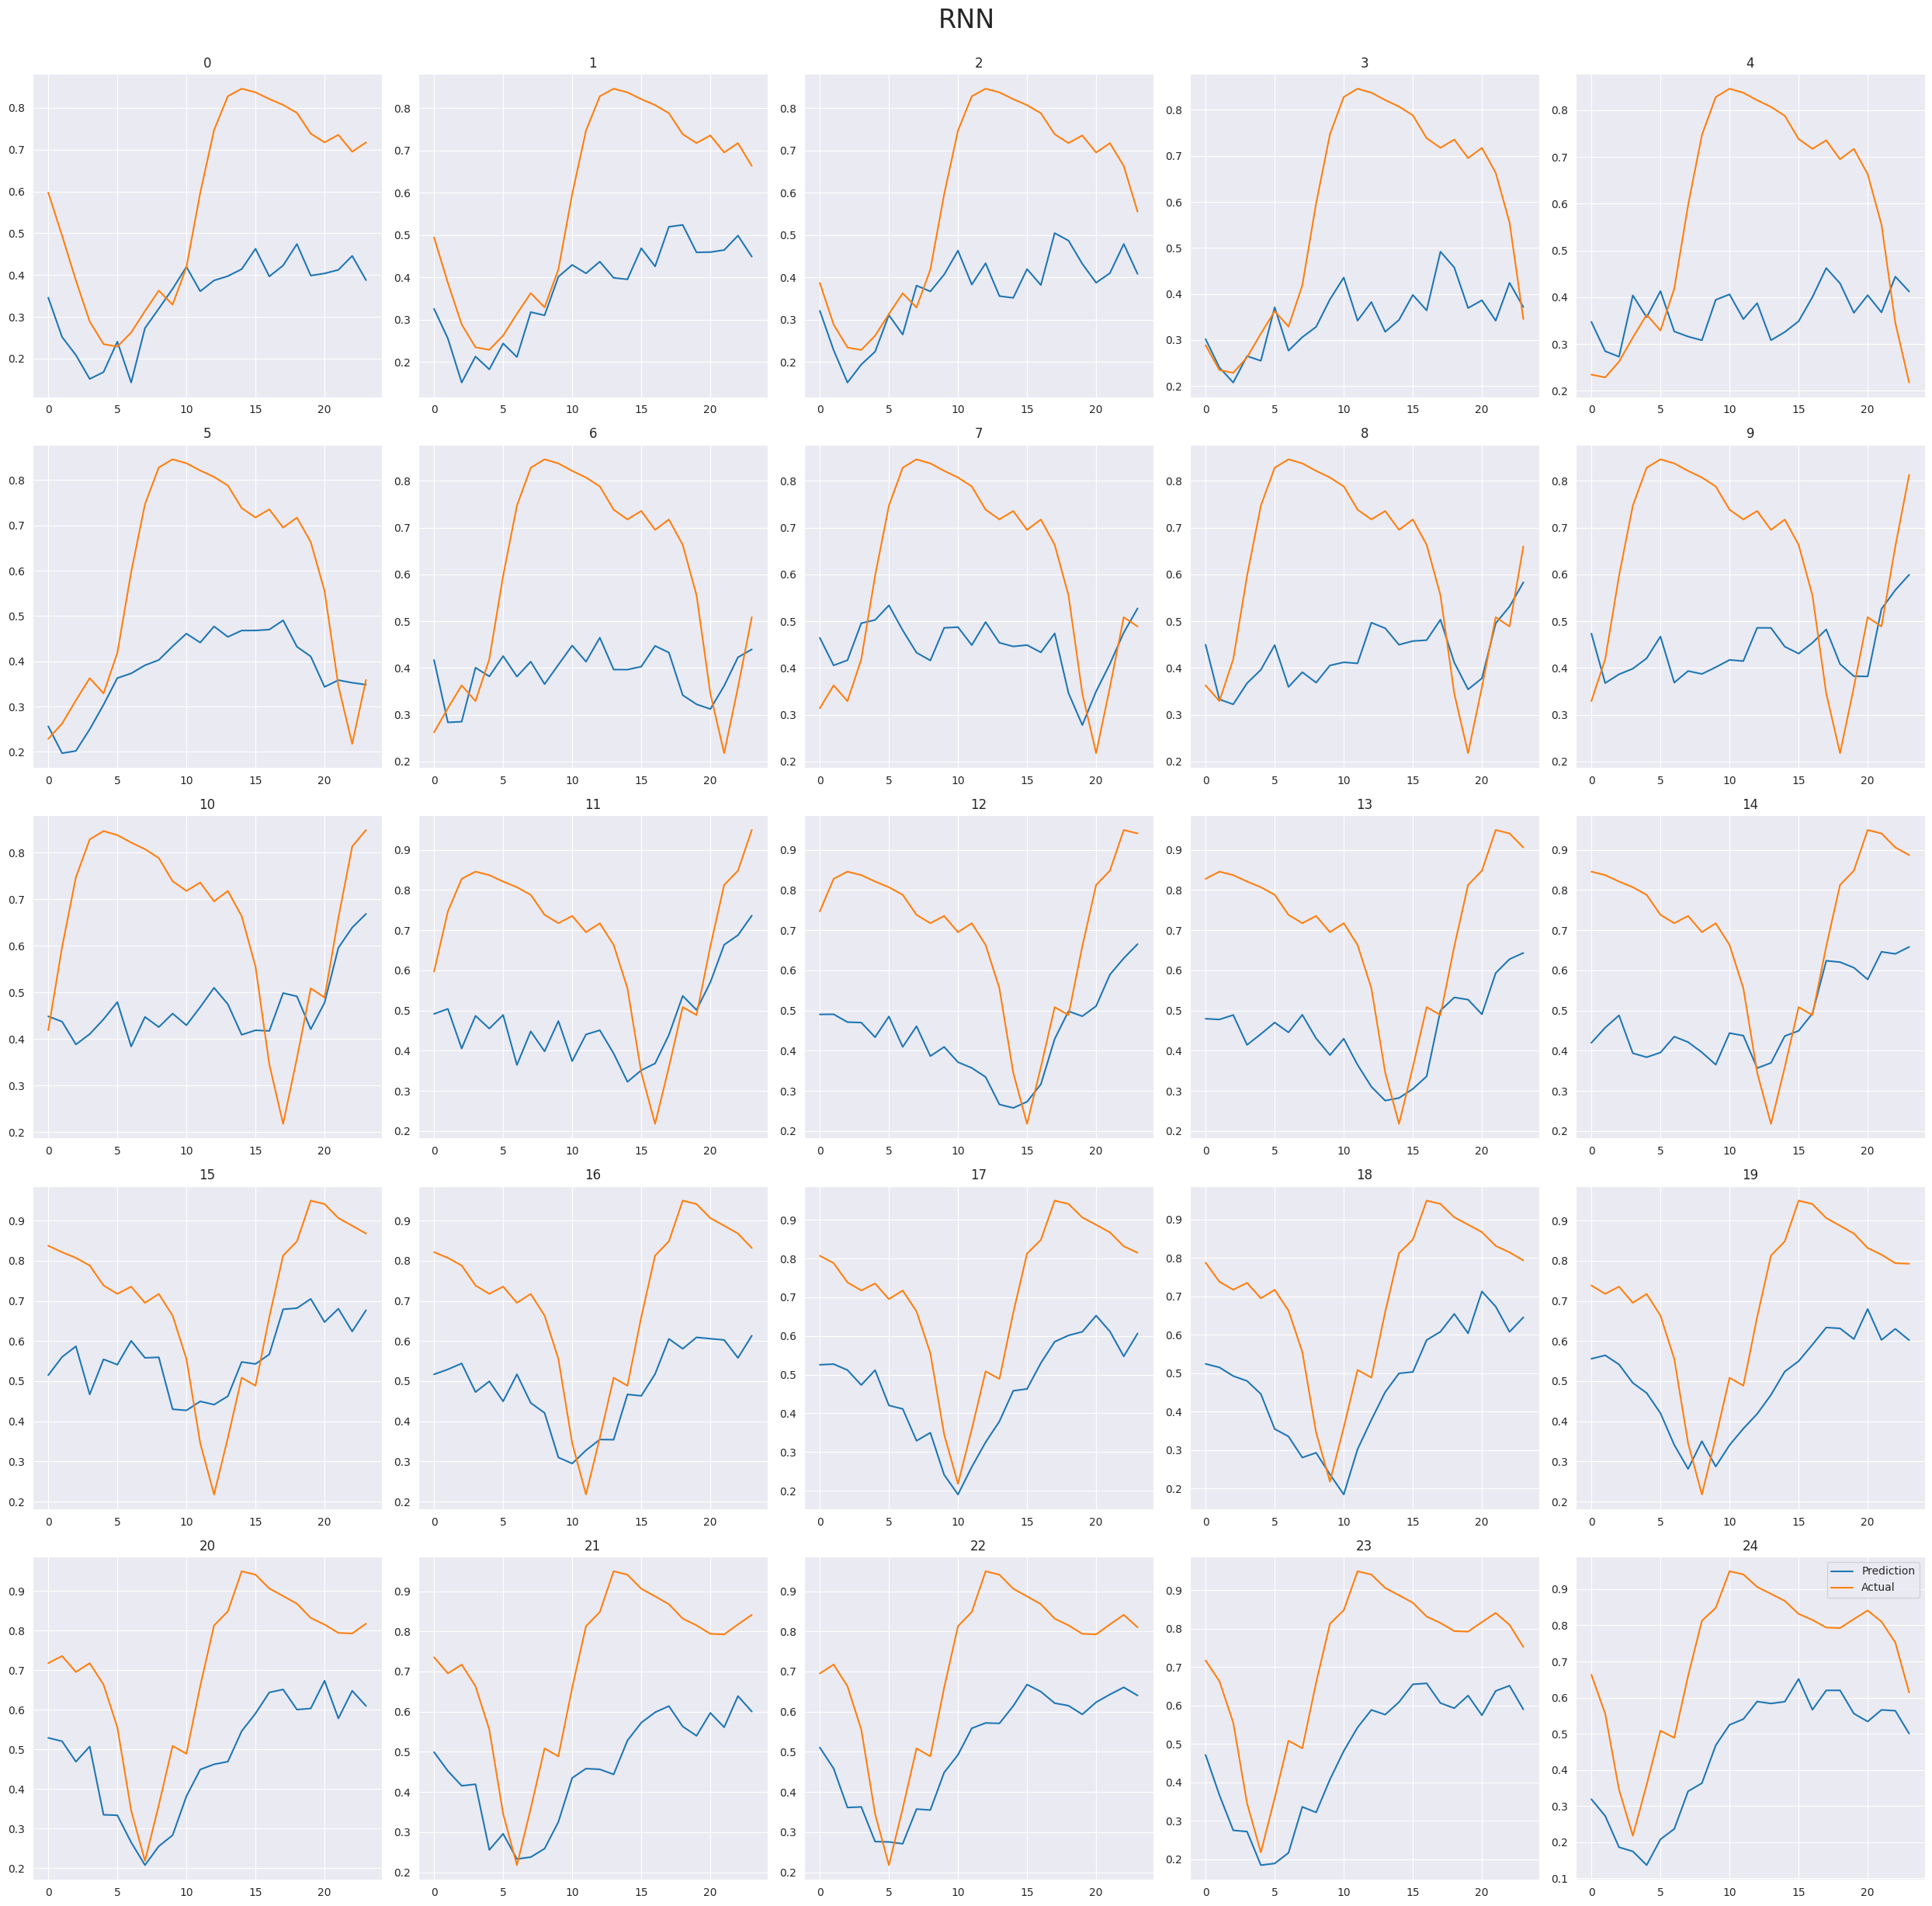

In [70]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(target_variables[i], label="Actual")
    ax.title.set_text(i)
    
fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [76]:
# TODO how to exactly evaluate since it's not just a one value but 24? For now I just did the average score from the 25 predictions, taking MSE for the 24 values

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = 0
for i in range(len(predictions)):
    print(sqrt(mean_squared_error(predictions[i][0], target_variables[i])))
    rmse += sqrt(mean_squared_error(predictions[i][0], target_variables[i]))

rmse /= len(predictions)    
print(f"RMSE = {rmse}")

0.2745385462777945
0.24560285237614352
0.26823353218954216
0.29294087746308883
0.3059417287542876
0.2520085914866505
0.2774861853553637
0.23719776050440317
0.26633868153148565
0.2733457861516758
0.26310170472676286
0.26187034392993097
0.28553989517632405
0.281085398293938
0.2754198496902298
0.19944733621862287
0.24474975608863125
0.2535748970119008
0.24670422819402293
0.23024713618306686
0.2408523533376392
0.2743952474491432
0.22573255667957412
0.258064933987689
0.2824190119564125
RMSE = 0.260673567640573


AttributeError: 'Sequential' object has no attribute 'eval'

In [ ]:
# LSTM, GRU, MLP
# baseline is linear RNN

LSTM

In [61]:
# initializing the LSTM
model_LSTM = keras.Sequential([
        
        # TODO I think this might be needed to group by timestamps rather than variables
        keras.layers.Permute((2,1), input_shape=(48,50)),
        
        # TODO does it make sense to stack them? should the number of units be equal to dimensions?
        keras.layers.LSTM(48, activation='tanh', return_sequences=True),
        # keras.layers.Dropout(0.2),   no dropout yet
        keras.layers.LSTM(48, activation='tanh', return_sequences=True),
        keras.layers.LSTM(24, activation='tanh', return_sequences=True),
        keras.layers.Dense(24)
    ]) #amount of layers & neurons to be adjusted


# compiling RNN
model_LSTM.compile(optimizer = SGD(learning_rate=0.01, 
                                  momentum=0.9, 
                                  nesterov=True), 
                  loss = "mean_squared_error")
 
model_LSTM.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_10 (Permute)        (None, 50, 48)            0         
                                                                 
 lstm_18 (LSTM)              (None, 50, 48)            18624     
                                                                 
 lstm_19 (LSTM)              (None, 50, 48)            18624     
                                                                 
 lstm_20 (LSTM)              (None, 50, 24)            7008      
                                                                 
 dense_18 (Dense)            (None, 50, 24)            600       
                                                                 
Total params: 44856 (175.22 KB)
Trainable params: 44856 (175.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
# fitting the model
history_LSTM = model_LSTM.fit(input_sequences, target_variables, epochs = 100, verbose=1)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1046, in launch_instance

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib64/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib64/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib64/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib64/python3.11/asyncio/events.py", line 80, in _run

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_43240/700752189.py", line 2, in <module>

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/home/matejpriesol/Documents/thesis-forecasting/venv/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

Incompatible shapes: [32,50,24] vs. [32,24]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_74786]

In [53]:
loss_per_epoch = model_LSTM.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
# Evaluate the model on the test data
predictions = []
#print(len(eval_target_variables))

for i in range(len(eval_target_variables)):
    current_batch = eval_input_sequences[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, 50))
    curr_pred = model.predict(current_batch)
    predictions.append(curr_pred)

#print(predictions)

GRU

In [63]:
# initializing the LSTM
model_GRU = keras.Sequential([
        
        keras.layers.Permute((2,1), input_shape=(48,50)),
        # include a flatten layer to convert to 1D (used as a first layer instead of reshaping)
        keras.layers.Flatten(input_shape=(50,48)),
        
        keras.layers.GRU(48, activation='tanh', return_sequences=True),
        # keras.layers.Dropout(0.2),   no dropout yet
        keras.layers.GRU(48, activation='tanh', return_sequences=True),
        keras.layers.GRU(24, activation='tanh', return_sequences=True),
        keras.layers.Dense(24)
    ]) #amount of layers & neurons to be adjusted


# compiling RNN
model_GRU.compile(optimizer = SGD(learning_rate=0.01, 
                                  momentum=0.9, 
                                  nesterov=True), 
                  loss = "mean_squared_error")
 
model_GRU.summary()

ValueError: Input 0 of layer "gru_3" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2400)